- Max Heading Difference between two consecutive waypoints
- Change in 1 second


# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dir/home/ababil/BUET/AV/Behavior Hypotheses/behavior-hypotheses/src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [5]:
sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [6]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

using min Y displacement (5)


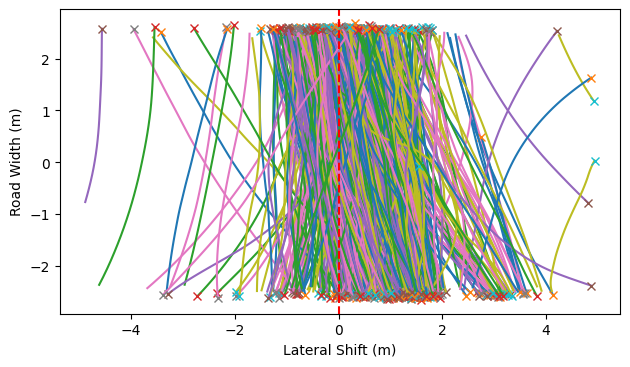

7600

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


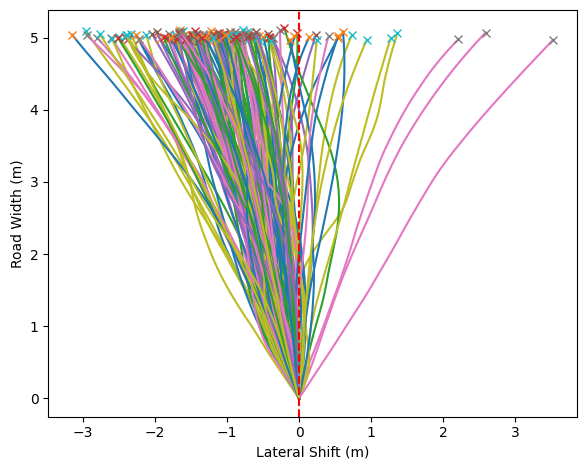

In [8]:
visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

### Right side of the vertical axis (clockwise) is negative

In [9]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [10]:
# plt.boxplot(startingDf["speed"])

In [11]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

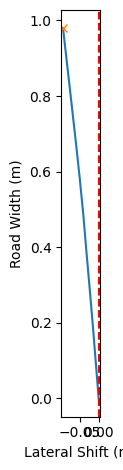

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [10]:
starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# starting023.size
starting023

In [ ]:
angular023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
angular023

In [ ]:
angularStartingDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(startingDf)
angularStartingDf

In [13]:
# max absolute value of angular displacement
maxAngularDisplacement = angularStartingDf["relativeAngularDisplacement"].abs().max()
# get the rows with max angular displacement
maxAngularDisplacementDf = angularStartingDf[angularStartingDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
maxAngularDisplacementDf

NameError: name 'angularStartingDf' is not defined

In [14]:
# get the whole track of the pedestrian with max angular displacement
maxAngularDisplacementPedId = maxAngularDisplacementDf.iloc[0]["uniqueTrackId"]
maxAngularDisplacementPedDf = angularStartingDf[angularStartingDf["uniqueTrackId"] == maxAngularDisplacementPedId].copy()
maxAngularDisplacementPedDf

NameError: name 'maxAngularDisplacementDf' is not defined

In [15]:
def findMaxAngularDisplacementPedDf(df):
    angularDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(df)
    # get the max angular displacement
    maxAngularDisplacement = angularDf["absoluteAngularDisplacement"].max()
    # get the rows with max angular displacement
    maxAngularDisplacementDf = angularDf[angularDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
    return maxAngularDisplacementDf

findMaxAngularDisplacementPedDf(cleanPedDf)



,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
169,27,7322,27159,211,5.0,-1.085564,0.304545,-0.095337,0.600084,0.079995,-0.034642,0.60761,0.666289,2.137224,0.087174,0.160433,2.151848,0.784789,0.784789


In [16]:
# plot a graph between absolute angular displacement and speed at each datapoint
plt.scatter(angularStartingDf["speed"], angularStartingDf["absoluteAngularDisplacement"])

NameError: name 'angularStartingDf' is not defined

In [19]:
# categorize speed 
# 0-0.5, 0.5-1, 1-10
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])

In [12]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10]
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=bins, labels=[f'{i}-{i+0.1}' for i in bins[:-1]])

In [13]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.4-0.5
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0.4-0.5
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,0.4-0.5
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.4-0.5
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.4-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,0.6-0.7
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,0.6-0.7
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,0.6-0.7
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,0.6-0.7


In [14]:
cleanPedDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)

In [15]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,relativeAngularDisplacement,absoluteAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.4-0.5,0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0.4-0.5,0.000000,0.000000
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,0.4-0.5,-0.016269,0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.4-0.5,0.099034,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.4-0.5,0.088696,0.088696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,0.6-0.7,0.111100,0.111100
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,0.6-0.7,0.119128,0.119128
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,0.6-0.7,0.127614,0.127614
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,0.6-0.7,0.132349,0.132349


In [16]:
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
len(allPedIds)
for pedId in allPedIds:
    pedDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    # sum of absolute angular displacement each 10 rows of the df
    sumAngularDisplacementInASecond = pedDf["absoluteAngularDisplacement"].rolling(10).sum()
    # add the value as a new column
    cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'sumAngularDisplacementInASecond'] = sumAngularDisplacementInASecond
    
cleanPedDf
    

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,...,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,relativeAngularDisplacement,absoluteAngularDisplacement,sumAngularDisplacementInASecond
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,...,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.4-0.5,0.000000,0.000000,NaN
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,...,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0.4-0.5,0.000000,0.000000,NaN
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,...,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,0.4-0.5,-0.016269,0.016269,NaN
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,...,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.4-0.5,0.099034,0.099034,NaN
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,...,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.4-0.5,0.088696,0.088696,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,...,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,0.6-0.7,0.111100,0.111100,0.770067
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,...,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,0.6-0.7,0.119128,0.119128,0.833709
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,...,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,0.6-0.7,0.127614,0.127614,0.883582
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,...,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,0.6-0.7,0.132349,0.132349,0.942762


In [17]:
# max angular displacement in a second
maxAngularDisplacementInASecond = cleanPedDf["sumAngularDisplacementInASecond"].max()
print(maxAngularDisplacementInASecond)
# for each speed category, get the max angular displacement in a second
maxAngularDisplacementInASecondBySpeedCategory = cleanPedDf.groupby('speedCategory')['sumAngularDisplacementInASecond'].max()
maxAngularDisplacementInASecondBySpeedCategory

17.528857329687582


speedCategory
0-0.1                            NaN
0.1-0.2                     0.633441
0.2-0.30000000000000004     1.004281
0.3-0.4                     6.139317
0.4-0.5                    17.528857
0.5-0.6                    14.817168
0.6-0.7                    15.045314
0.7-0.7999999999999999      8.170658
0.8-0.9                     8.453377
0.9-1.0                    10.341389
1-1.1                       2.059256
Name: sumAngularDisplacementInASecond, dtype: float64

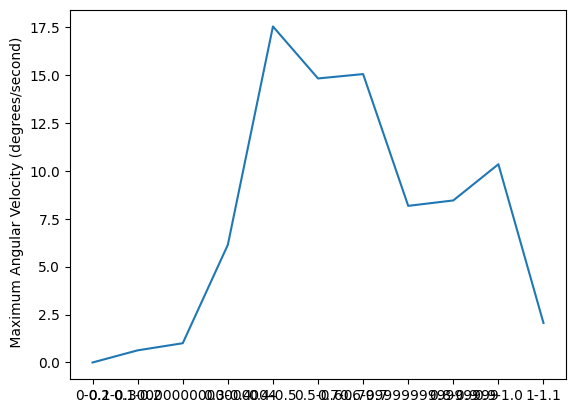

In [18]:
# plot the max and the mean angular displacement in a second by speed category
# fill the NaN with 0
maxAngularDisplacementInASecondBySpeedCategory.fillna(0, inplace=True)

plt.plot(maxAngularDisplacementInASecondBySpeedCategory)
# plt.plot(meanAngularDisplacementInASecondBySpeedCategory, label="Mean Angular Velocity")
# plt.legend()
# plt.xlabel("Speed Category")
plt.ylabel(" Maximum Angular Velocity (degrees/second)")
plt.show()

In [31]:
sumAngularDisplacementInASecond = angularStartingDf["absoluteAngularDisplacement"].rolling(10).sum()
sumAngularDisplacementInASecond

NameError: name 'angularStartingDf' is not defined

In [32]:
# find the max angular displacement for each speed category
def findMaxAngularDisplacement(df):
    # get the max angular displacement
    maxAngularDisplacement = df["relativeAngularDisplacement"].abs().max()
    return maxAngularDisplacement

maxAngularDisplacementDf = cleanPedDf.groupby('speedCategory').apply(findMaxAngularDisplacement)
maxAngularDisplacementDf

speedCategory
(0.0, 0.1]          NaN
(0.1, 0.2]          NaN
(0.2, 0.3]          NaN
(0.3, 0.4]          NaN
(0.4, 0.5]          NaN
(0.5, 0.6]     0.781956
(0.6, 0.7]     0.784789
(0.7, 0.8]     0.549545
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
(1.0, 1.1]          NaN
(1.1, 1.2]          NaN
(1.2, 1.3]          NaN
(1.3, 1.4]          NaN
(1.4, 1.5]          NaN
(1.5, 1.6]          NaN
(1.6, 1.7]          NaN
(1.7, 1.8]          NaN
(1.8, 1.9]          NaN
(1.9, 2.0]          NaN
(2.0, 10.0]         NaN
dtype: float64

In [ ]:
# find the max angular displacement for each speed category in each scene
def getMaxAngularDisplacementScenewise(sceneId, date, fps, dataDir, minYDisplacement, maxXDisplacement):
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer = TrajectoryTransformer(colMapper)
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0, # we can consider them as obstacles
        maxSpeed = 3.5,
        minAcceleration = 0.0,
        maxAcceleration = 2.0,   
        minYDisplacement = minYDisplacement,
        maxXDisplacement = maxXDisplacement
    )
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    transformer.deriveAcceleration(pedDf)
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)

    southIds = []
    for pedId in allPedIds:
        trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
        trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
        # print(trackMeta['verticalDirection'])
        if trackMeta['verticalDirection'] == "SOUTH":
            southIds.append(pedId)
            # print(trackMeta["uniqueTrackId"])
            X, Y = transformer.rotate(trackDf)
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
    # len(cleanPedDf)

    angularDisplacementDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)
    angularDisplacementDf['speedCategory'] = pd.cut(angularDisplacementDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])
    maxAngularDisplacementDf = angularDisplacementDf.groupby('speedCategory').apply(findMaxAngularDisplacement)
    return maxAngularDisplacementDf

scenes = [210, 211, 220, 221, 230, 231, 240, 222]
scenesMaxAngularDisplacement = []
for sceneId in scenes:
    scenesMaxAngularDisplacement.append(getMaxAngularDisplacementScenewise(sceneId, "2023-05-04", 10, dataDir, 5, 6))

using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)


ValueError: No objects to concatenate

In [ ]:
scenesMaxAngularDisplacementDf = pd.concat(scenesMaxAngularDisplacement, axis=1)
scenesMaxAngularDisplacementDf.columns = scenes[:5]
scenesMaxAngularDisplacementDf

In [ ]:
# plot distribution of angular displacement for each speed category
sns.displot(cleanPedDf, x="absoluteAngularDisplacement", hue="speedCategory", kind="kde", fill=True)
plt.xlabel("Absolute Angular Displacement")
plt.ylabel("Density")

plt.show()


In [ ]:
# write a function for getting the above plot for given sceneId
def getAngularDisplacementDistribution(sceneId, date, fps, dataDir, minYDisplacement, maxXDisplacement):
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer = TrajectoryTransformer(colMapper)
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0, # we can consider them as obstacles
        maxSpeed = 3.5,
        minAcceleration = 0.0,
        maxAcceleration = 2.0,   
        minYDisplacement = minYDisplacement,
        maxXDisplacement = maxXDisplacement
    )
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    transformer.deriveAcceleration(pedDf)
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)

    southIds = []
    for pedId in allPedIds:
        trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
        trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
        # print(trackMeta['verticalDirection'])
        if trackMeta['verticalDirection'] == "SOUTH":
            southIds.append(pedId)
            # print(trackMeta["uniqueTrackId"])
            X, Y = transformer.rotate(trackDf)
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
    # len(cleanPedDf)

    angularDisplacementDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)
    angularDisplacementDf['speedCategory'] = pd.cut(angularDisplacementDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])
    sns.displot(angularDisplacementDf, x="absoluteAngularDisplacement", hue="speedCategory", kind="kde", fill=True)
    plt.xlabel("Absolute Angular Displacement")
    plt.ylabel("Density")
    plt.title(f"Scene {sceneId}")
    plt.show()
    
getAngularDisplacementDistribution(210, "2023-05-04", 10, dataDir, 5, 6)

In [ ]:
# plot for all scenes from scenes array
scenes = [210, 211, 220, 221, 230, 231, 240, 222]
for sceneId in scenes:
    getAngularDisplacementDistribution(sceneId, "2023-05-04", 10, dataDir, 5, 6)

In [ ]:
NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

In [ ]:
def maxAngDisVsSpeed(dataframe):
    
    total_length = len(dataframe)
    maxAngularDisplacementDf = findMaxAngularDisplacementPedDf(dataframe)
    col1 = 'maxAngularDisplacement'
    col2 = 'Speed'

    maxAngularDisplacementDf['category1'] = assign_category(maxAngularDisplacementDf[col1], NO_OF_CATEGORY)
    maxAngularDisplacementDf['category2'] = assign_category(maxAngularDisplacementDf[col2], NO_OF_CATEGORY)

    heatmapDf = pd.DataFrame(columns = [col1, col2, 'count'])
    heatmapDf['maxAngularDisplacement'] = maxAngularDisplacementDf['category1']
    heatmapDf['Speed'] = maxAngularDisplacementDf['category2']
    heatmapDf['count'] = 1
    heatmapDf = heatmapDf.groupby(['maxAngularDisplacement', 'Speed']).count().reset_index()
    
    heatmapDf = heatmapDf.pivot(index='maxAngularDisplacement', columns='Speed', values='count')

    # heatmapDf_swap = find_RankA(heatmapDf)
    df = heatmapDf.iloc[::-1]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df/total_length, annot=True, fmt=".6f", cmap='YlGnBu')
    
    x_labels = ["low", "medium", "high"]
    y_labels = ["high", "medium", "low"]
    
    count = 3
    
    plt.xticks(np.arange(0.5, count+0.5, 1), x_labels)
    plt.yticks(np.arange(0.5, count+0.5, 1), y_labels)

    plt.xlabel("Speed")
    plt.ylabel("maxAngularDisplacement")

    plt.show()


In [ ]:
maxAngDisVsSpeed(cleanPedDf)